# Cloud Optical Thickness Prediction from Imaging Satellite Instruments

In [204]:
import os
import torch
from torch import nn
import torch.utils.data as Data
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import xarray as xr
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.special import logit
from multiprocessing import Process
from time import perf_counter

import matplotlib.pyplot as plt

In [133]:
from pkg.helpers import (
    get_seed,
    get_local_variability_names,
    get_reflectance_names,
    get_angle_names,
    land_mask_to_one_hot_array,
)

In [184]:
file_path ='rt_nn_cloud_training_data_20230118.nc'
ds = xr.open_dataset(file_path)
ds

<xarray.Dataset>
Dimensions:                        (npoints: 173252, nbands_oci: 223, nbands_modis: 11, nbands_viirs: 10)
Coordinates:
  * nbands_oci                     (nbands_oci) float32 350.0 ... 2.261e+03
  * nbands_modis                   (nbands_modis) float32 412.0 ... 2.13e+03
  * nbands_viirs                   (nbands_viirs) float32 412.0 ... 2.25e+03
Dimensions without coordinates: npoints
Data variables:
    solar_zenith_angle             (npoints) float32 ...
    viewing_zenith_angle           (npoints) float32 ...
    relative_azimuth_angle         (npoints) float32 ...
    albedo_type                    (npoints) int16 ...
    oci_reflectances               (nbands_oci, npoints) float32 ...
    modis_reflectances             (nbands_modis, npoints) float32 ...
    viirs_reflectances             (nbands_viirs, npoints) float32 ...
    scene_type                     (npoints) int16 ...
    log10_cloud_optical_thickness  (npoints) float32 ...
    spress                         (npoints) float32 ...
    h2o                            (npoints) float32 ...
    o3                             (npoints) float32 ...
Attributes:
    description:             Radiative transfer-based labelled training data ...
    suffix:                  nc
    version:                 Created 20230118
    contact_person_address:  NASA/GSFC, Mail Code 616, 8800 Greenbelt Road, G...
    contact_person_email:     andrew.sayer@nasa.gov
    contact_person_name:      Andrew Sayer
    contact_person_role:     Scientific/technical contact
    data_set_language:       en
    file_format:             NetCDF4

In [185]:
# split three instruments and build three models
oci_reflectances = ds["oci_reflectances"].values 
modis_reflectances = ds["modis_reflectances"].values 
viirs_reflectances = ds["viirs_reflectances"].values 
nbands_oci = ds["nbands_oci"].values
nbands_modis = ds["nbands_modis"].values
nbands_viirs = ds["nbands_viirs"].values
angles = ds[["solar_zenith_angle", "viewing_zenith_angle", "relative_azimuth_angle"]].to_array().values
h2o = ds["h2o"].values
o3 = ds["o3"].values
scene_type = ds["scene_type"].values
albedo_type = ds["albedo_type"].values
spress = ds["spress"].values
cot = ds["log10_cloud_optical_thickness"].values

In [187]:
oci_reflectances

array([[0.241643 , 0.239398 , 0.779062 , ..., 0.695469 , 0.334966 ,
        0.245042 ],
       [0.23702  , 0.234367 , 0.779951 , ..., 0.694667 , 0.330755 ,
        0.240479 ],
       [0.232397 , 0.23     , 0.779308 , ..., 0.692716 , 0.326125 ,
        0.236331 ],
       ...,
       [0.106719 , 0.239471 , 0.471263 , ..., 0.216993 , 0.230466 ,
        0.0473236],
       [0.0539665, 0.116122 , 0.398838 , ..., 0.151903 , 0.166353 ,
        0.0386443],
       [0.0486109, 0.112743 , 0.558129 , ..., 0.267866 , 0.161492 ,
        0.0363805]], dtype=float32)

### Scale reflectances

In [137]:
# def process_reflectances(reflectances, epsilon):
#     """
#     normalizes each nbands to have the range of 0-1, then performs logit.

#     :param: reflectances: n x m matrix, n is each sd(which is 3) and m is observations.

#     """

#     for i in range(len(reflectances)):
#         new_range = (0 + epsilon, 1 - epsilon)
#         reflectances[i] = logit(np.interp(reflectances[i], (np.min(reflectances[i]), np.max(reflectances[i])), new_range))

In [138]:
# epsilon = 10**-4
# process_reflectances(oci_reflectances, epsilon) 
# process_reflectances(modis_reflectances, epsilon)
# process_reflectances(viirs_reflectances, epsilon)

In [139]:
# process_reflectances(nbands_oci, epsilon)
# process_reflectances(nbands_modis, epsilon)
# process_reflectances(nbands_viirs, epsilon)

In [140]:
# def process_angles(angles):
#     """
#     standard normalization to the same range of reflectances

#     """

#     for i in range(len(angles)):
#         angles[i] = (angles[i] - np.mean(angles[i]))/np.std(angles[i])        

In [141]:
# # Normalized to [0,1] will be fine for the first experiment
# process_angles(angles)
# process_angles(modis_reflectances)
# process_angles(oci_reflectances)
# process_angles(viirs_reflectances)
# h2o = (h2o - np.mean(h2o))/np.std(h2o) 
# o3 = (o3 - np.mean(o3))/np.std(o3) 
# spress = (spress - np.mean(spress))/np.std(spress) # Can transfer to standard atomospheric pressure
# albedo_type = (albedo_type -np.mean(albedo_type))/np.std(albedo_type)   # class - cut down the number of classes
# # scene_type  = (scene_type - np.mean(scene_type))/np.std(scene_type)     # class - directly related to COT (only have value when cloudy)

In [188]:
cot = np.nan_to_num(cot, nan=-2) # 0 if below -10 in log space ; but should consider the cut-off
print(np.mean(cot), np.std(cot))

-0.3366962 1.2485716


In [143]:
# cot = (cot - np.mean(cot))/np.std(cot) 

## Concatenate variables and split training-testing dataset

In [189]:
X = np.concatenate((oci_reflectances, h2o[None, :], o3[None, :], spress[None, :], scene_type[None, :], albedo_type[None,:], angles), axis=0) # n x m, where n = 22
# X = np.transpose(X) # transpose into a m x n matrix , n = 22 (aka features) and m = rows (aka observations)

# Y represents the response vector (binary),,,, m by 1, m = rows (aka observations)
Y = cot
# Y = np.reshape(Y, (-1, 1)) # reshape to m x 1 array

In [190]:
print(X.shape, Y.shape)

(231, 173252) (173252,)


In [191]:
X = np.transpose(X)

In [194]:
scale = StandardScaler()
X_s = scale.fit_transform(X)

In [195]:
X_train, X_test, y_train, y_test = train_test_split(X_s, Y, test_size=0.33, random_state=42)

# Prepare Data for Training

In [196]:
X_train_t = torch.from_numpy(X_train.astype(np.float32))
y_train_t = torch.from_numpy(y_train.astype(np.float32))
X_test_t = torch.from_numpy(X_test.astype(np.float32))
y_test_t = torch.from_numpy(y_test.astype(np.float32))

In [212]:
dataset_train = Data.TensorDataset(X_train_t, y_train_t)
dataset_test = Data.TensorDataset(X_test_t, y_test_t)
train_loader = DataLoader(dataset = dataset_train, batch_size = 64, shuffle=True, pin_memory=True)
validate_loader = DataLoader(dataset = dataset_test, batch_size = 64, shuffle=True, pin_memory=True)

In [148]:
# class MyDataset(Dataset):
#     def __init__(self,data_x, data_y):
#         self.data_x = data_x
#         self.data_y = data_y
#     def __getitem__(self, index):
#         x = self.data_x[index]
#         x = torch.from_numpy(x.astype(np.float32))
#         y = self.data_y[index]
#         y = torch.from_numpy(y.astype(np.float32))
#         return x,y
#     def __len__(self):
#         return self.data_x.shape[0]

# Network

In [221]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self, input_size):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(input_size, 64),
      nn.BatchNorm1d(64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.BatchNorm1d(32),
      nn.ReLU(),
      nn.Linear(32, 1)
    )


  def forward(self, x):
    '''
      Forward pass
    '''
    return self.layers(x)

# Optimization

In [222]:
# Initialize the MLP
mlp = MLP(input_size=X_train_t.shape[1])
  
# Define the loss function and optimizer
loss_function = nn.L1Loss() # Pay attention to the threshold between cloud and non-cloud pxiels # add penalty to -1.5
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.0001)

In [223]:
# Run the training loop
train_loss_all = []
valid_loss_all = []
for epoch in range(50): # 5 epochs at maximum
  
  # Print epoch
  print(f'Starting epoch {epoch+1}')
  
  # Set current loss value
  train_loss = 0.0
  valid_loss = 0.0
  train_num = 0
  valid_num = 0
  
  # Iterate over the DataLoader for training data
  for step, (b_x,b_y) in enumerate(train_loader):
    output = mlp(b_x)
    loss = loss_function(output, b_y)
    optimizer.zero_grad
    loss.backward()
    optimizer.step()
    train_loss +=loss.item() * b_x.size(0)
    train_num += b_x.size(0)
  train_loss_all.append(train_loss / train_num)

  for setp, (c_x, c_y) in enumerate(validate_loader):
    output_valid = mlp(c_x)
    loss_v = loss_function(output_valid,c_y)
    valid_loss +=loss_v.item() * c_x.size(0)
    valid_num += c_x.size(0)

  valid_loss_all.append(valid_loss / train_num)
  print("Train Loss: {}, Valid Loss: {}".format ((train_loss / train_num), (valid_loss / valid_num)))  

# Process is complete.
print('Training process has finished.')

Starting epoch 1


/Users/xingyanli/opt/anaconda3/envs/gestar2/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/Users/xingyanli/opt/anaconda3/envs/gestar2/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([46])) that is different to the input size (torch.Size([46, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/Users/xingyanli/opt/anaconda3/envs/gestar2/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([22, 1])). This will likely lead to incorrect 

Train Loss: 1.0565128866461477, Valid Loss: 1.0490912833577268
Starting epoch 2
Train Loss: 1.0481742017540954, Valid Loss: 1.049144298840066
Starting epoch 3
Train Loss: 1.0481783330176588, Valid Loss: 1.0491015766609977
Starting epoch 4
Train Loss: 1.0485319201578478, Valid Loss: 1.048269939323777
Starting epoch 5
Train Loss: 1.0483668954904093, Valid Loss: 1.0493645366826896
Starting epoch 6
Train Loss: 1.0484633996034425, Valid Loss: 1.048439925434282
Starting epoch 7
Train Loss: 1.0485463166878122, Valid Loss: 1.0492776882804011
Starting epoch 8
Train Loss: 1.0487972533771246, Valid Loss: 1.0495046220325484
Starting epoch 9
Train Loss: 1.0484903147129456, Valid Loss: 1.048634600063042
Starting epoch 10
Train Loss: 1.0482186923117165, Valid Loss: 1.0493276434425594
Starting epoch 11
Train Loss: 1.0484469686674072, Valid Loss: 1.0482149606703979
Starting epoch 12
Train Loss: 1.048378838947104, Valid Loss: 1.0491983533451856
Starting epoch 13
Train Loss: 1.0483035545538577, Valid Los

# Visualization

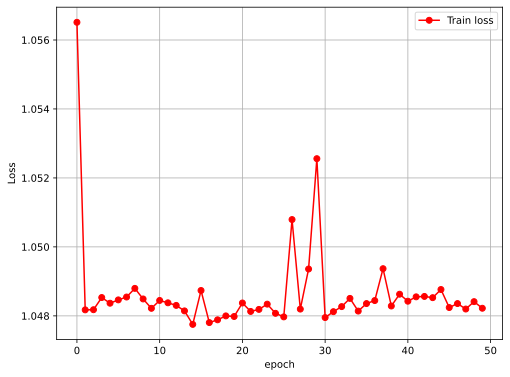

In [224]:
plt.figure(figsize = (8,6))
plt.plot(train_loss_all, 'ro-', label = 'Train loss')
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()